<a href="https://colab.research.google.com/github/allbert4/MED_263_Group_1/blob/main/MED263_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This notebook walks through the entire pipeline of preparing data, fine tuning a model, and evaluating its performance.

Goals: understand how to use and fine-tune a Vision Transformer model for image classification using Hugging Face's Transformers library.

For more information, see [detailed tutorial explanation here](https://github.com/allbert4/MED_263_Group_1/blob/main/MED263_Group1_FinalTutorialReport.pdf).

#Step 1: Install and Import Libraries

In [ ]:

# @title Install Dependencies: takes 1-2 minutes to run
!pip install transformers datasets evaluate accelerate pillow torchvision scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
import torch
import torchvision
import numpy as np
import evaluate
from datasets import load_dataset
from huggingface_hub import notebook_login
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import DefaultDataCollator
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt

# Step 2: Load Dataset

In [ ]:
# @title Download data from github

! git clone https://github.com/allbert4/MED_263_Group_1

Cloning into 'MED_263_Group_1'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 4), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 25.84 MiB | 29.59 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [ ]:
# @title Unpackage image data into Colab file system

import zipfile
import os

# Define paths
zip_path = "/content/MED_263_Group_1/HAM10000_sampled_100_balance.zip"  # TODO
extract_path = "HAM10000_images"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Images extracted to:", extract_path)


Images extracted to: HAM10000_images


In [ ]:
# @title Load labels from Github data labels file
import pandas as pd

labels_path = "/content/MED_263_Group_1/HAM10000_sampled_100bal_metadata.csv"
df = pd.read_csv(labels_path)

# Display the first few rows
print(df.head())


     lesion_id      image_id   dx dx_type   age     sex     localization  \
0  HAM_0004884  ISIC_0025937  bkl   histo  75.0    male  upper extremity   
1  HAM_0007409  ISIC_0025642  bkl   histo  50.0    male  upper extremity   
2  HAM_0002299  ISIC_0025819  bkl   histo  75.0  female             face   
3  HAM_0005693  ISIC_0027781  bkl   histo  80.0    male             back   
4  HAM_0002392  ISIC_0028233  bkl   histo  55.0    male             face   

        dataset  
0  vidir_modern  
1  vidir_modern  
2  vidir_modern  
3     rosendahl  
4     rosendahl  


In [ ]:
# @title Convert data to Huggingface dataset
from datasets import Dataset

base_path = extract_path + "/HAM10000_sampled_100_balance/"
dataset_dict = {
    "image": [os.path.join(base_path, img + ".jpg") for img in df["image_id"]],
    "label": df["dx"].tolist()
}

num_classes = len(set(df["dx"]))

dataset = Dataset.from_dict(dataset_dict)
print(dataset)

Dataset({
    features: ['image', 'label'],
    num_rows: 100
})


In [ ]:
# @title Check for missing images- should be 0
missing_files = [img for img in dataset["image"] if not os.path.exists(img)]
print(f"Missing images: {len(missing_files)}")
assert len(missing_files) == 0, "Files not found, check your file directory paths"

Missing images: 0


In [ ]:
# Problem: labels are strings. We need to convert them to integers
# show example
dataset[0]['label']

'bkl'

In [ ]:
# @title Assign indices to class labels

unique_labels = sorted(set(dataset["label"]))  # Ensure consistent ordering
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

print("Label Mapping:", label2id)

Label Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [ ]:
# @title Convert labels to integers

def convert_labels(example):
    example["label"] = label2id[example["label"]]
    return example

dataset = dataset.map(convert_labels)

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# Now labels are integers!
# Show example
dataset[0]['label']

2

In [ ]:
# Convert to Image Dataset
from datasets import Image

dataset = dataset.cast_column("image", Image())

In [ ]:
# @title Train/test data split
split_dataset = dataset.train_test_split(test_size=0.2)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

#Step 3: Data Visualization and Statistics

In [ ]:
print(train_dataset[0])

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A3083F24B90>, 'label': 3}


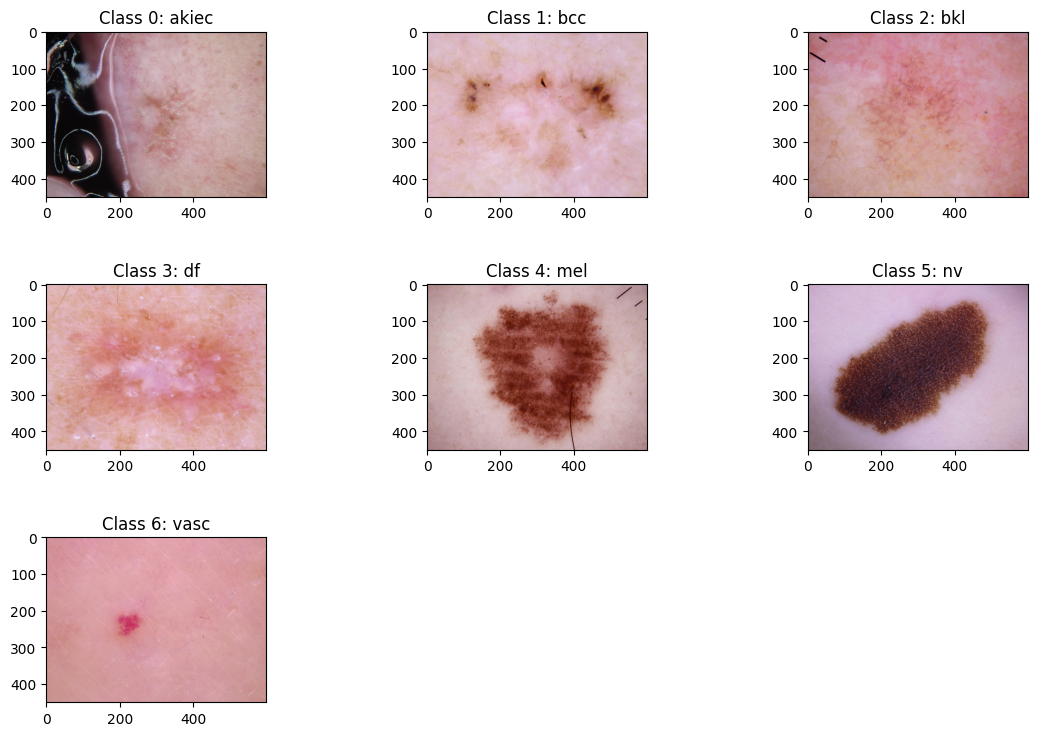

In [ ]:
# @title Visualize a few example images from each class
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
images = []
for label in range(num_classes):
    for example in train_dataset:
      if example["label"] == label:
          image=example["image"]
          images.append(image)
          break

for cls, img in enumerate(images):
  plt.subplot(3, 3, cls+1)
  plt.imshow(images[cls], cmap="gray")
  plt.title(f"Class {cls}: {id2label[cls]}")

plt.tight_layout(pad=3.0)
plt.show()

## Next we visualize the distribution of our dataset.

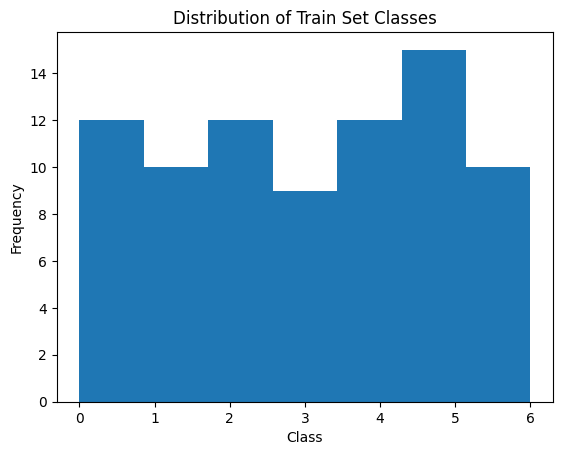

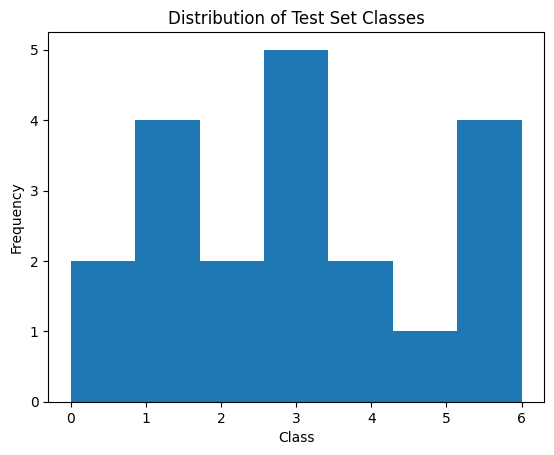

In [ ]:
labs = [example["label"] for example in train_dataset]
plt.hist(labs, bins=num_classes)

# Add title and labels
plt.title('Distribution of Train Set Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Show the plot
plt.show()

labs = [example["label"] for example in test_dataset]
plt.hist(labs, bins=num_classes)

# Add title and labels
plt.title('Distribution of Test Set Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')

# Show the plot
plt.show()


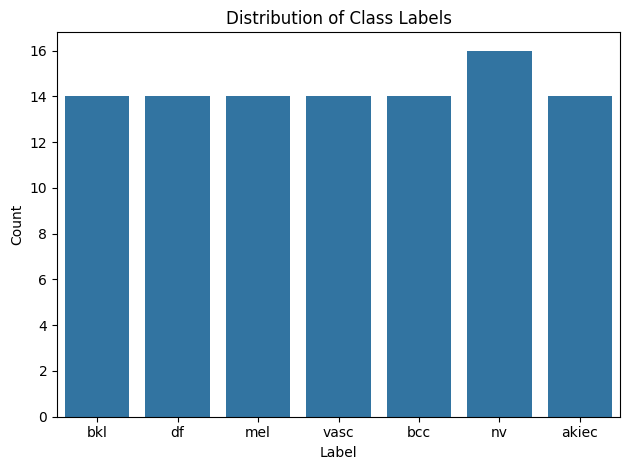

In [ ]:
# Visualize training data statistics

# Label Statistics
import seaborn as sns

dx_col = df['dx']
sns.countplot(x=dx_col, data=df)
plt.title('Distribution of Class Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

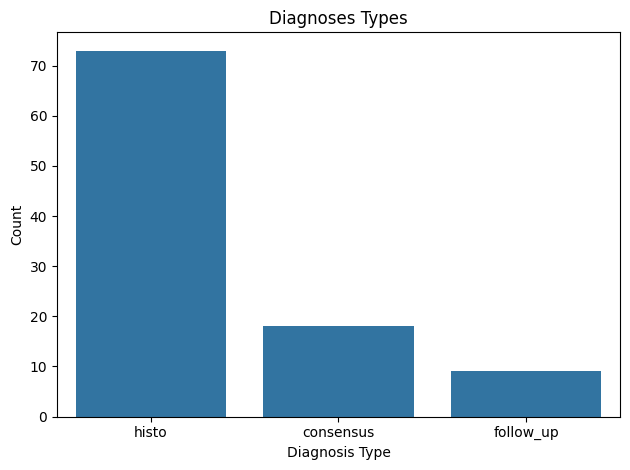

In [ ]:
# Visualize Distribution for Diagnoses Type

dx_type_col = df['dx_type']
sns.countplot(x=dx_type_col, data=df)
plt.title('Diagnoses Types')
plt.xlabel('Diagnosis Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

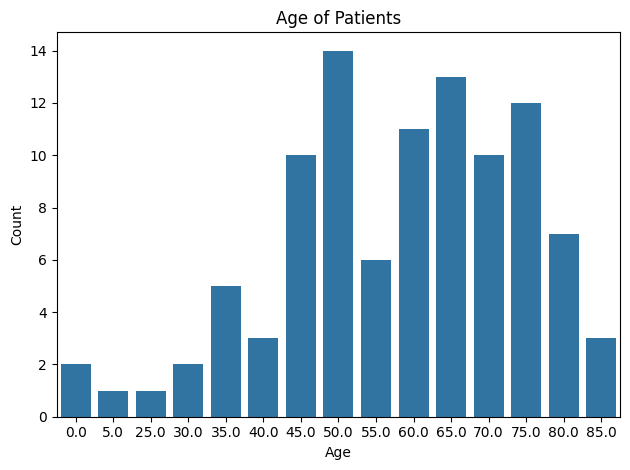

In [ ]:
# Visualize Distribution of Age of Patients

age_col = df['age']
sns.countplot(x=age_col, data=df)
plt.title('Age of Patients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

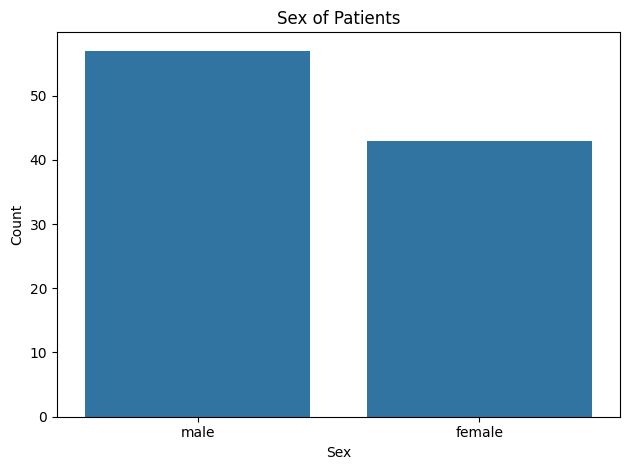

In [ ]:
# Visualize Distribution of Sex of Patients

sex_col = df['sex']
sns.countplot(x=sex_col, data=df)
plt.title('Sex of Patients')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

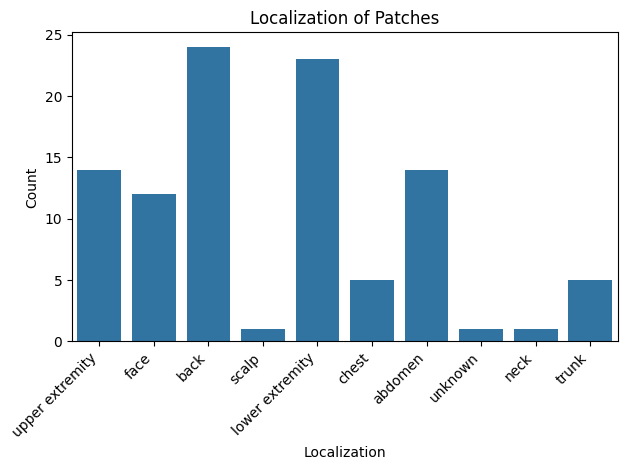

In [ ]:
# Visualize Distribution of Localization

localization_col = df['localization']
sns.countplot(x=localization_col, data=df)
plt.title('Localization of Patches')
plt.xlabel('Localization')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#Step 4: Load Models

In [ ]:
# @title Load base model and image processor

checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
# @title Do some image transformations to make the model more resistant to overfitting, and crop to correct size for model
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)

size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)

_transforms = Compose([
    RandomResizedCrop(size),
    ToTensor(),  # Convert to tensor
    normalize  # Apply normalization
])

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples


In [ ]:
# @title Preprocess over entire dataset
train_dataset = train_dataset.with_transform(transforms)
test_dataset = test_dataset.with_transform(transforms)

In [ ]:
# @title Batch examples
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [ ]:
# @title Set up evaluation metrics
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

#Step 5: Fine tune models

In [ ]:

# @title Set up model
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=num_classes
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# @title Hyperparameters

training_args = TrainingArguments(
    output_dir="tuned_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,                     # Learning rate
    lr_scheduler_type="cosine",
    per_device_train_batch_size=16,         # Batch size train
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=16,          # Batch size eval
    num_train_epochs=30,                    # Number of epochs
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    processing_class=image_processor
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.958100,2.002107,0.150000
2,1.936100,1.959851,0.050000
3,1.859400,1.959147,0.100000
4,1.788000,1.904389,0.150000
5,1.692600,1.907419,0.100000
6,1.592100,1.828389,0.400000
7,1.468300,1.749920,0.400000
8,1.354300,1.687552,0.450000
9,1.280100,1.604344,0.450000
10,1.190000,1.571713,0.500000


TrainOutput(global_step=150, training_loss=0.9752642154693604, metrics={'train_runtime': 313.8926, 'train_samples_per_second': 7.646, 'train_steps_per_second': 0.478, 'total_flos': 1.859891095093248e+17, 'train_loss': 0.9752642154693604, 'epoch': 30.0})

#Step 6: Evaluate Performance
todo:
-  Evaluate model performance on validation set using:
  - Accuracy (using `evaluate.load("accuracy")`)
  - Precision, Recall, F1-score (using `precision_recall_fscore_support`)
  - View the trend of loss and accuracy curve
  - Confusion Matrix (for error analysis)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

predictions_output = trainer.predict(test_dataset)

predicted_labels = np.argmax(predictions_output.predictions, axis=1)

true_labels = predictions_output.label_ids

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    if predictions.ndim > 1:
        predictions = np.argmax(predictions, axis=1)

    print(f"Predictions shape: {predictions.shape}, Labels shape: {labels.shape}")  # Debugging step

    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=1)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1-score": f1
    }

metrics = compute_metrics((predicted_labels, true_labels))
print(metrics)

Predictions shape: (20,), Labels shape: (20,)
{'accuracy': 0.6, 'precision': 0.6158333333333333, 'recall': 0.6, 'f1-score': 0.5871428571428571}


In [ ]:
for log in trainer.state.log_history:
    print(log) #Check whether loss decreases

{'loss': 1.9581, 'grad_norm': 1.8231526613235474, 'learning_rate': 1.6666666666666667e-05, 'epoch': 1.0, 'step': 5}
{'eval_loss': 2.0021066665649414, 'eval_accuracy': 0.15, 'eval_runtime': 0.614, 'eval_samples_per_second': 32.574, 'eval_steps_per_second': 3.257, 'epoch': 1.0, 'step': 5}
{'loss': 1.9361, 'grad_norm': 1.7651110887527466, 'learning_rate': 3.3333333333333335e-05, 'epoch': 2.0, 'step': 10}
{'eval_loss': 1.9598509073257446, 'eval_accuracy': 0.05, 'eval_runtime': 0.5969, 'eval_samples_per_second': 33.508, 'eval_steps_per_second': 3.351, 'epoch': 2.0, 'step': 10}
{'loss': 1.8594, 'grad_norm': 1.673661231994629, 'learning_rate': 5e-05, 'epoch': 3.0, 'step': 15}
{'eval_loss': 1.9591474533081055, 'eval_accuracy': 0.1, 'eval_runtime': 0.3534, 'eval_samples_per_second': 56.594, 'eval_steps_per_second': 5.659, 'epoch': 3.0, 'step': 15}
{'loss': 1.788, 'grad_norm': 1.7733430862426758, 'learning_rate': 4.983095894354858e-05, 'epoch': 4.0, 'step': 20}
{'eval_loss': 1.904388666152954, '

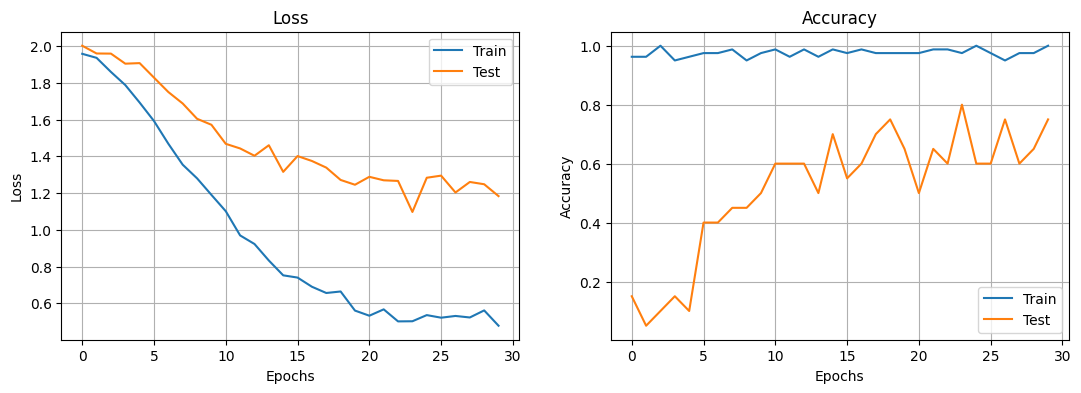

In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

for epoch in range(1, int(trainer.state.epoch) + 1):
    train_predictions = trainer.predict(train_dataset)
    train_preds = train_predictions.predictions.argmax(axis=1)
    train_labels = train_predictions.label_ids
    train_accuracy = accuracy_score(train_labels, train_preds)

    trainer.state.log_history.append({"epoch": epoch, "train_accuracy": train_accuracy})

metrics = trainer.state.log_history

train_loss = [entry["loss"] for entry in metrics if "loss" in entry]
test_loss = [entry["eval_loss"] for entry in metrics if "eval_loss" in entry]

train_accuracy = [entry["train_accuracy"] for entry in metrics if "train_accuracy" in entry]
test_accuracy = [entry["eval_accuracy"] for entry in metrics if "eval_accuracy" in entry]


plt.figure(figsize=(13,4))

# Loss Curve
plt.subplot(1,2,1)
plt.title("Loss")
plt.plot(train_loss, label="Train")
plt.plot(test_loss, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend(loc="best")

# Accuracy Curve
plt.subplot(1,2,2)
plt.title("Accuracy")
plt.plot(train_accuracy, label="Train")
plt.plot(test_accuracy, label="Test")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend(loc="best")

plt.show()

In [ ]:
print("Unique values in true_labels:", np.unique(true_labels))
print("Class distribution in true_labels:", np.bincount(true_labels))


Unique values in true_labels: [0 1 2 3 4 5 6]
Class distribution in true_labels: [2 4 2 5 2 1 4]


In [ ]:
from sklearn.metrics import classification_report
import numpy as np

predictions_output = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions_output.predictions, axis=1)
true_labels = predictions_output.label_ids

report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.33      0.25      0.29         4
           2       0.67      1.00      0.80         2
           3       0.50      0.40      0.44         5
           4       1.00      0.50      0.67         2
           5       0.50      1.00      0.67         1
           6       0.80      1.00      0.89         4

    accuracy                           0.55        20
   macro avg       0.54      0.59      0.54        20
weighted avg       0.54      0.55      0.53        20



[[0 1 0 1 0 0 0]
 [0 1 1 1 0 0 1]
 [0 0 2 0 0 0 0]
 [1 1 0 2 0 1 0]
 [1 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 4]]


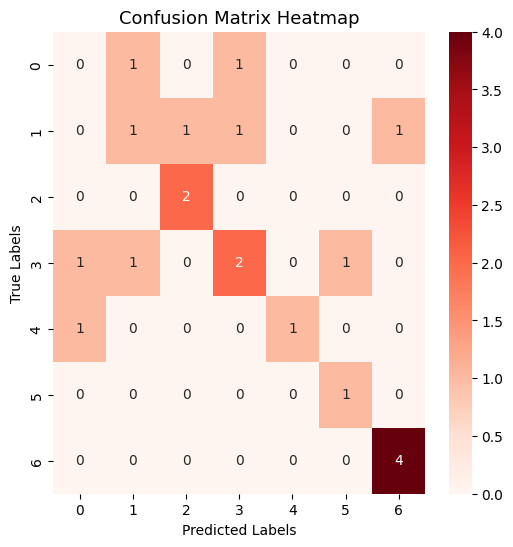

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(true_labels, predicted_labels)
print(cm)

all_labels = np.unique(np.concatenate((true_labels, predicted_labels)))
plt.figure(figsize=(6,6))
plt.title("Confusion Matrix Heatmap", fontsize=13)
sns.heatmap(cm, cmap="Reds", annot=True, fmt="d", xticklabels=all_labels, yticklabels=all_labels)

plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

In [ ]:
import random
correct_idxs = [i for i in range(len(true_labels)) if predicted_labels[i] == true_labels[i]]
incorrect_idxs = [i for i in range(len(true_labels)) if predicted_labels[i] != true_labels[i]]

sample_correct = random.sample(correct_idxs, min(4, len(correct_idxs)))
sample_incorrect = random.sample(incorrect_idxs, min(4, len(incorrect_idxs)))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, idx in enumerate(sample_correct):
    img = test_dataset[idx]["pixel_values"].permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"True: {id2label[true_labels[idx]]}\nPredicted: {id2label[predicted_labels[idx]]}")
    axes[0, i].axis("off")

for i, idx in enumerate(sample_incorrect):
    img = test_dataset[idx]["pixel_values"].permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"True: {id2label[true_labels[idx]]}\nPredicted: {id2label[predicted_labels[idx]]}")
    axes[1, i].axis("off")

plt.show()


#Step 7: Model Optimization: Trying Different Models and Hyperparameters

In [ ]:
# @title Load base model and image processor

checkpoint = "microsoft/swin-tiny-patch4-window7-224"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [ ]:
# @title Set up model
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# @title Hyperparameters
training_args = TrainingArguments(
    output_dir="tuned_model",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-4,                     # Learning rate
    lr_scheduler_type="cosine",
    per_device_train_batch_size=16,         # Batch size train
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=16,          # Batch size eval
    num_train_epochs=30,                    # Number of epochs
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    processing_class=image_processor
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1-score
1,1.967600,1.973592,0.150000,0.533333,0.150000,0.152381
2,1.783000,1.832109,0.200000,0.584821,0.200000,0.138889
3,1.502200,1.482941,0.400000,0.533333,0.400000,0.375595
4,1.229600,1.453991,0.650000,0.796250,0.650000,0.632784
5,1.186100,1.487711,0.400000,0.670000,0.400000,0.397619
6,1.253100,1.619394,0.450000,0.648333,0.450000,0.390173
7,1.201100,1.598847,0.450000,0.533333,0.450000,0.453571
8,0.998800,2.091463,0.500000,0.716667,0.500000,0.489524
9,1.061700,2.234891,0.400000,0.668254,0.400000,0.315584
10,0.980600,2.020402,0.300000,0.675000,0.300000,0.270476


Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels shape: (20,)
Predictions shape: (20,), Labels s

TrainOutput(global_step=150, training_loss=0.6755237120389939, metrics={'train_runtime': 183.0032, 'train_samples_per_second': 13.115, 'train_steps_per_second': 0.82, 'total_flos': 5.96627080003584e+16, 'train_loss': 0.6755237120389939, 'epoch': 30.0})